# GZ Data Reduction: Binning & Cleaning

This notebook takes in raw (alpha level) Galaxy Zoo data and produces a binned output catalogue, a cleaned user-weighted output catalogue, and the associated user weights catalogue. 

Functions below are derived from [gz_reduce.py](https://github.com/bamford/gz_reduce/blob/master/gz_reduce.py) and [gz_reduce_gama_combined_clean.py](https://github.com/bamford/gz_reduce/blob/master/gz_reduce_gama_combined_clean.py), produced by Steven Bamford. Original cleaning efforts can also be found [on Dropbox](https://www.dropbox.com/sh/sd6meqzm8rktxfd/AABRfLFNJtrzolQKqFnnD3tfa?dl=0).

In [1]:
# imports
import os
import sys
import warnings
import math
import numpy as np
from numpy import ma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic, gaussian_kde
from scipy.optimize import minimize, curve_fit
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import (Table, hstack, join, vstack,
                           Column, MaskedColumn)
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import imageio
import time
import string
import gzip
import re
import json

# Notebook startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
nbtf = '%Y-%m-%d %H:%M:%S %Z'
nbt0 = time.time()
nbt0str = time.strftime(nbtf, time.localtime(nbt0))
print(f'Notebook start time: \n   {nbt0str}')
#--------------------------------68-------------------------------->
# np.seterr(divide='raise')

Notebook start time: 
   2020-10-19 13:27:24 CDT


## Fns from: `gz_reduce.py`

In [2]:
def parse_tree(stub):
    """Parse a Galaxy Zoo coffeescript tree description file."""
    questions = []
    answers = []
    letters = string.ascii_lowercase
    f = open('{}_tree.coffee'.format(stub))
    for l in f:
        ls = l.strip().split(',')
        if len(ls) > 0:
            lss_full = ls[0].replace('"', '').replace("'", "")
            lss = lss_full.split(maxsplit=1)
        if len(lss) > 1:
            test = lss[0].startswith
            value = lss[1].lower().replace(' ', '_')
            if test('@question'):
                qi = 0
                if value in questions:
                    questions[questions.index(value)] += '_a'
                while '{}_{}'.format(value,
                                     letters[qi]) in questions:
                    qi += 1
                if qi > 0:
                    value = '{}_{}'.format(value, letters[qi])
                questions.append(value)
                answers.append([])
            elif test('@checkbox'):
                answers[-1].append((value, 'x'))
            elif test('@answer'):
                if value != 'done':
                    answers[-1].append((value, 'a'))
    return questions, answers

In [3]:
def count_matches(col, test, group=None, anywhere=True, weights=1):
    """Count the matches of `test` in `col` grouped by `group`
       If `group` is `None`, return `True` for matches."""
    if anywhere:
        matches = np.zeros(len(col), np.bool)
        matches[~col.mask] = np.array([test in x.split(';')
                                       for x in col[~col.mask]])
    else:
        matches = col == test
    if group is not None:
        matches = matches * weights
        matches = Column(matches).group_by(group)
        count = matches.groups.aggregate(np.sum)
        return count
    else:
        return matches

In [4]:
def collate_classifications(indata, stub, questions, answers):
    """Reduce a GZ classification DB dump to a vote frac. table"""
    outdata = Table()
    outdata['subject_id'] = np.unique(indata['subject_id'])
    qindex = 0
    if 'weight' in indata.colnames:
        weights = indata['weight'].filled(0)
    else:
        weights = 1
    for cc in indata.columns:
        if cc.startswith(stub):
            qq = questions[qindex]
            outcols = Table()
            for aindex, (aa, qtype) in enumerate(answers[qindex]):
                test = '{}-{}'.format(qtype, aindex)
                count = count_matches(indata[cc], test,
                                      indata['subject_id'],
                                      anywhere=(qtype == 'x'),
                                      weights=weights)
                name = '{}_{}'.format(qq, aa)
                outcols[name] = count
                if aindex == 0:
                    total = count
                else:
                    total += count
            name = '{}_total'.format(qq)
            outdata[name] = total
            outdata = hstack([outdata, outcols])
            qindex += 1
    return outdata

In [5]:
def recalculate_odd_total(data):
    """Adjust for skipping odd Q without providing any answer."""
    data = data.copy()
    if 'odd_total' in data.colnames:
        data['odd_total'] = (data['features_total'] -
                             data['features_star_or_artifact'])
    if 'oddtype_total' in data.colnames:
        data['oddtype_total'] = (data['features_total'] -
                                 data['features_star_or_artifact'])
    return data

In [6]:
def calculate_fractions(data, questions, answers,
                        remove_counts=True):
    """Reduce a GZ classification DB dump to table of vote fracs."""
    data = data.copy()
    for qindex in range(len(questions)):
        qq = questions[qindex]
        for aindex, (aa, qtype) in enumerate(answers[qindex]):
            name = '{}_{}'.format(qq, aa)
            totalname = '{}_total'.format(qq)
            fracname = '{}_frac'.format(name)
            data[fracname] = data[name] / data[totalname]
            if remove_counts:
                data.remove_column(name)
    return data

In [7]:
# def read_subjects(infile, stub, survey_id_field):
#     """Parse a dump of Ouroboros subject table to get useful ids."""
#     subject_id = []
#     survey_id = []
#     zooniverse_id = []
#     # tmp = ''
#     for line in gzip.open(infile):
#         line = line.decode("utf-8")
#         # # fix corruption (if nec. - match cleaned ver. by Lee)
#         # if re.search('ouroboros', line) is not None:
#         #     tmp += re.sub('2017-03.*ouroboros.*', '', line)[:-1]
#         #     continue
#         # if tmp != '':
#         #     line = tmp + line
#         #     tmp = ''
#         if re.search(stub, line) is not None:
#             ls = line.strip().split(',', maxsplit=3)
#             match = re.match('ObjectId\((.+)\)', ls[0])
#             subject_id.append(match.group(1))
#             zooniverse_id.append(ls[1])
#             metadata = ls[3].replace('""', '"')[1:-1]
#             metadata = json.loads(metadata)
#             if survey_id_field in metadata.keys():
#                 survey_id.append(metadata[survey_id_field])
#             else:
#                 survey_id.append(None)
#     subjects = Table([np.array(subject_id),
#                       np.array(survey_id, dtype=np.str),
#                       np.array(zooniverse_id)],
#                      names=('subject_id', 'survey_id',
#                             'zooniverse_id'))
#     return subjects

In [8]:
# def reduce_data(date, tree='gama', subjectset='gama09',
#                 survey_id_field='provided_image_id',
#                 subjectcat='galaxy_zoo_subjects_lee.csv.gz',
#                 subjectstub=None):
#     """Do everything to produce reduced table of ids/vote fracs."""
#     questions, answers = parse_tree(tree)
#     template = '{}_galaxy_zoo_{}_classifications.csv'
#     indata = Table.read(template.format(date, subjectset),
#                         fast_reader=False)
#     outdata = collate_classifications(indata, tree,
#                                       questions, answers)
#     outdata = recalculate_odd_total(outdata)
#     outdata = calculate_fractions(outdata, questions, answers)
#     if subjectstub is None:
#         subjectstub = subjectset
#     subjects = read_subjects(subjectcat, subjectstub,
#                              survey_id_field)
#     outdata = join(outdata, subjects, 'subject_id')
#     return outdata

## Fns from: `gz_reduce_gama_combined_clean.py`

In [9]:
def evaluate_data(indata, outdata, stub, user='user'):
    data = join(indata, outdata,
                keys='subject_id', join_type='left')
    evaluation = data[['subject_id', user, 'weight']]
    evaluation['consistency'] = ma.masked_array(0.0)
    evaluation['agreement'] = ma.masked_array(0.0)
    nanswered = np.zeros(len(data), np.int)
    qindex = 0
    for cc in indata.columns:
        if cc.startswith(stub):
            qq = questions[qindex]
            if ('discuss' in qq) or ('odd' in qq):
                qindex += 1
                continue
            tname = '{}_total'.format(qq)
            total = data[tname]
            consistency = np.zeros(len(data))
            crossentropy = np.zeros(len(data))
            answered = np.zeros(len(data), np.bool)
            for aindex, (aa, qtype) in enumerate(answers[qindex]):
                print(qindex, qq, aindex, aa)
                test = '{}-{}'.format(qtype, aindex)
                match = count_matches(data[cc], test,
                                      anywhere=(qtype == 'x'))
                if qindex == 0 and aindex == 2:
                    artifact = np.where(match, 1, 0)
                    ###!!!### continue  # ignore artifact answers
                answered |= match
                name = '{}_{}'.format(qq, aa)
                fname = '{}_frac'.format(name)
                pp = data[fname]
                consistencyi = np.where(match, pp, 1 - pp)
                total = total.clip(min=1)
                minprob = 0.1 / total
                pp = pp.clip(min=minprob)  # bound the min. prob.
                crossentropyi = -np.where(match, 1, 0) * np.log(pp)
                consistency += consistencyi
                crossentropy += crossentropyi
                if qindex == 0 and aindex == 2:
                    artifact = np.where(match, 1, 0)
            nqanswers = len(answers[qindex])
            consistency /= nqanswers
            agreement = (1 - crossentropy) / np.log(nqanswers)
            # ignore and mask questions that are not answered
            consistency[~answered] = 0
            agreement[~answered] = 0
            name = '{}_consistency'.format(qq)
            evaluation[name] = ma.masked_array(consistency)
            evaluation['consistency'] += evaluation[name]
            evaluation[name].mask = ~answered
            name = '{}_agreement'.format(qq)
            evaluation[name] = ma.masked_array(agreement)
            evaluation['agreement'] += evaluation[name]
            evaluation[name].mask = ~answered
            nanswered += np.where(answered, 1, 0)
            qindex += 1
    evaluation['nanswered'] = ma.masked_array(nanswered)
    evaluation['consistency'] /= ma.masked_array(nanswered)
    evaluation['agreement'] /= ma.masked_array(nanswered)
    evaluation['artifact'] = ma.masked_array(artifact)
    evaluation = evaluation.group_by(user)
    evaluation_user = evaluation.groups.aggregate(ma.mean)
    evaluation['count'] = ma.masked_array(1)
    user_count = evaluation[user, 'count', 'weight',
                            'artifact'].groups.aggregate(ma.sum)
    evaluation_user['count'] = user_count['weight']
    evaluation_user['artifact_fraction'] = (user_count['artifact'] /
                                            user_count['count'])
    evaluation_user.sort('consistency')
    return evaluation, evaluation_user

In [10]:
def stripnan(x):
    return x[~np.isnan(x)]

In [11]:
def evaluation_plots(eval, title = '', figsize = (8,10), dpi = 150):

    fig, axarr = plt.subplots(3, 2, figsize=figsize, dpi=dpi)
    axarr = axarr.flat

    ax = axarr[0]
    for q in questions:
        name = '{}_consistency'.format(q)
        if name in eval.colnames:
            ax.hist(stripnan(eval[name]), label=q, histtype='step',
                    log=True, range=(0, 1), bins=25)
    ax.hist(eval['consistency'], label='total', histtype='step',
            color='k', lw=3, log=True,
            range=(0, 1), bins=25)
    ax.set_xlabel('consistency')
    ax.vlines(0.75, 0.1, 3000, linestyles='dotted')
    ax.set_xlim(0.0, 1.0)
    ax.legend(fontsize='xx-small')

    ax = axarr[1]
    for q in questions:
        name = '{}_agreement'.format(q)
        if name in eval.colnames:
            ax.hist(stripnan(eval[name]), label=q, histtype='step',
                    log=True, range=(-6, 3), bins=25)
    ax.hist(eval['agreement'], label='total', histtype='step',
            color='k', lw=3, log=True,
            range=(-6, 3), bins=25)
    ax.set_xlabel('agreement')
    ax.vlines(0.0, 0.1, 3000, linestyles='dotted')
    ax.set_xlim(-6, 3)
    ax.legend(fontsize='xx-small')

    ax = axarr[2]
    ax.scatter(eval['consistency'], eval['agreement'], marker='.',
               alpha=0.5, edgecolor='none',
               c=np.log10(eval['count']), vmin=-1, vmax=5)
    ax.set_xlim(0.4, 0.9)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('consistency')
    ax.set_ylabel('agreement')

    ax = axarr[3]
    ax.hist(np.log10(eval['count']))
    ax.set_xlim(-1, 5)
    ax.set_xlabel('$\log_{10}(count)$')

    ax = axarr[4]
    ax.scatter(np.log10(eval['count']), eval['consistency'],
               marker='.', alpha=0.5, edgecolor='none',
               c=np.log10(eval['count']), vmin=-1, vmax=5)
    ax.hlines(0.75, -0.25, 4.5)
    ax.set_xlim(-1, 5)
    ax.set_ylim(0.4, 0.9)
    ax.set_xlabel('$\log_{10}(count)$')
    ax.set_ylabel('consistency')

    ax = axarr[5]
    ax.scatter(np.log10(eval['count']), eval['agreement'],
               marker='.', alpha=0.5, edgecolor='none',
               c=np.log10(eval['count']), vmin=-1, vmax=5)
    ax.hlines(0, -0.25, 4.5)
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$\log_{10}(count)$')
    ax.set_ylabel('agreement')

    #ax.set_axis_off()
    fig.text(0.53, 0.985, title, ha='center', va='top',
             transform=fig.transFigure, fontsize='large')
    plt.tight_layout(rect=(0,0,1,0.97))

In [12]:
def iterate_weights(stage, indata, outdata, evaluation_user,
                    label, user = 'user'):
    # set weights, add to data table, iterate...
    evaluation_user['weight'] = ((evaluation_user['consistency'] /
                                  0.75)**10).clip(max=1)

    plot_consistency = np.linspace(0.0, 1.0, 1000)
    plot_weights = ((plot_consistency / 0.75)**10).clip(max=1)
    plt.plot(plot_consistency, plot_weights)
    plt.xlabel('consistency')
    plt.xlabel('weight')
    plt.savefig(f'{label}_combined_weights.pdf')

    user_weight = Table(evaluation_user[user, 'weight'],
                        masked=False)
    indata.remove_column('weight')
    indata = join(indata, user_weight, join_type='left',
                  keys=user)

    outdata = collate_classifications(indata, tree,
                                      questions, answers)
    outdata = recalculate_odd_total(outdata)
    outdata = calculate_fractions(outdata, questions, answers)

    evaluation, evaluation_user = evaluate_data(indata, outdata,
                                                tree, user)
    evaluation_user_avg = evaluation_user.groups.aggregate(
        np.nanmean)

    outshuffle = outdata.copy()
    perm = np.random.permutation(len(outdata))
    outshuffle['subject_id'] = outshuffle['subject_id'][perm]
    evalshuffle, evalshuffle_user = evaluate_data(indata,
                                                  outshuffle,
                                                  tree, user)
    evalshuffle_user_avg = evalshuffle_user.groups.aggregate(
        np.nanmean)

    evaluation_plots(evaluation_user, f'evaluation stage {stage}')
    plt.savefig('{}_evaluation_stage{}.pdf'.format(label, stage),
                dpi = 'figure')
    plt.close()

    evaluation_plots(evalshuffle_user, f'evalshuffle stage {stage}')
    plt.savefig('{}_evalshuffle_stage{}.pdf'.format(label, stage),
                dpi = 'figure')
    plt.close()
    return (indata, outdata,
            evaluation, evaluation_user, evaluation_user_avg,
            evalshuffle, evalshuffle_user, evalshuffle_user_avg)

## Config and Setup

In [13]:
# setup
tree = 'gama'
survey_id_field='provided_image_id'
label = 'gkgz'  # label = 'gama_combined_2018-02-25'
user_weights_outname = f'{label}-user_weights.fits.gz'
binned_outname = f'{label}-binned.fits.gz'
cleaned_outname = f'{label}-cleaned.fits.gz'
save_outputs = True

In [14]:
# get questions/answers from original GAMA CoffeeScript
questions, answers = parse_tree(tree)
display(dict(zip(questions, answers)))

{'features': [('smooth', 'a'), ('features', 'a'), ('star_or_artifact', 'a')],
 'edgeon': [('yes', 'a'), ('no', 'a')],
 'bar': [('bar', 'a'), ('no_bar', 'a')],
 'spiral': [('spiral', 'a'), ('no_spiral', 'a')],
 'bulge': [('no_bulge', 'a'), ('obvious', 'a'), ('dominant', 'a')],
 'spiralwinding': [('tight', 'a'), ('medium', 'a'), ('loose', 'a')],
 'spiralnumber': [('1', 'a'),
  ('2', 'a'),
  ('3', 'a'),
  ('4', 'a'),
  ('more_than_4', 'a')],
 'bulgeshape': [('rounded', 'a'), ('boxy', 'a'), ('no_bulge', 'a')],
 'round': [('completely_round', 'a'),
  ('in_between', 'a'),
  ('cigar_shaped', 'a')],
 'mergers': [('merging', 'a'),
  ('tidal_debris', 'a'),
  ('both', 'a'),
  ('neither', 'a')],
 'oddtype': [('none', 'x'),
  ('ring', 'x'),
  ('lens_or_arc', 'x'),
  ('irregular', 'x'),
  ('other', 'x'),
  ('dust_lane', 'x'),
  ('overlapping', 'x')],
 'discuss': [('yes', 'a'), ('no', 'a')]}

## Read In Data and Prepare

In [15]:
# read in binned data
indata_unmasked = Table.read('../gkgz-alpha.fits.gz')
indata = Table(indata_unmasked, masked=True)
indata['weight'] = MaskedColumn(np.ones(len(indata)))

In [16]:
# raw data preview
display(indata[0:2].to_pandas().T)

,0,1
id,b'588f50c17d25c730ea00018c',b'588f51777d25c76f920000e5'
subject_id,b'5857c531d369fd0040005911',b'5857c532d369fd00400059df'
user_id,17536,2969
created_at,b'2017-01-30 14:42:09 UTC',b'2017-01-30 14:45:11 UTC'
lang,b'en ',b'ru '
user_agent,b'unknown ',b'unknown '
gama-0,b'a-1 ',b'a-1 '
gama-1,b'a-0',b'a-0'
gama-2,b' ',b' '
gama-3,b' ',b' '


In [17]:
%%time
# strip whitespace from answer data columns
rawdata = indata.copy()
for cc in rawdata.columns:
    if cc.startswith(tree):
        col = rawdata[cc]
        rawdata[cc] = ma.masked_array([x.strip(' ') for x in col])

CPU times: user 9min 28s, sys: 13.4 s, total: 9min 42s
Wall time: 9min 41s


In [18]:
# find unusual values in raw catalogue (client side caching issues?)
print('Unusual values in the raw catalogue:')
for ii, (qq, aa) in enumerate(zip(questions, answers)):
    colname = f'{tree}-{ii}'
    print(f'  {colname} ({qq}): ', end='')
    aa_allowed = [f'{aa[0][1]}-{i}' for i in np.arange(0,len(aa),1)]
    if aa_allowed[0] == 'x-0':
        aa_allowed.extend(['a-0', 'a-0;'])
    aa_allowed.append('')
    col = rawdata[colname]
    good_rows = [list((col == x).data) for x in aa_allowed]
    bad_rows = ~np.any(good_rows, axis=0)
    if np.sum(bad_rows) > 0:
        count = Counter(col[bad_rows])
    else:
        count = {}
    keys = list(count.keys())
    kstub = [x[:4] for x in keys]
    badkeys = [y for x, y in zip(kstub,keys) if x not in aa_allowed]
    badcount = {x:count[x] for x in badkeys}
    print(f'{badcount}')

Unusual values in the raw catalogue:
  gama-0 (features): {'a-3': 4, 'a-0;x-5': 1}
  gama-1 (edgeon): {}
  gama-2 (bar): {}
  gama-3 (spiral): {}
  gama-4 (bulge): {}
  gama-5 (spiralwinding): {}
  gama-6 (spiralnumber): {}
  gama-7 (bulgeshape): {}
  gama-8 (round): {}
  gama-9 (mergers): {}
  gama-10 (oddtype): {'a-3': 17, 'a-1': 7, 'a-2': 3}
  gama-11 (discuss): {'a-2': 5}


## Run Binning Routines

In [19]:
%%time
# collate raw alpha classifications into binned results
bindata0 = collate_classifications(rawdata,tree,questions,answers)

CPU times: user 5min 21s, sys: 5.42 s, total: 5min 27s
Wall time: 5min 32s


In [20]:
# adjust odd total values: accounts for users skipping this question
bindata0 = recalculate_odd_total(bindata0)

In [21]:
# replace answer totals with fractions
with np.errstate(invalid='ignore'):
    bindata = calculate_fractions(bindata0, questions, answers)

In [22]:
# binned data preview
display(bindata.to_pandas()[0:2].T)

,0,1
subject_id,b'5857c4a3d369fd0040000001',b'5857c4a3d369fd0040000003'
features_total,40,40
edgeon_total,4,5
bar_total,4,4
spiral_total,4,4
bulge_total,4,4
spiralwinding_total,0,1
spiralnumber_total,0,1
bulgeshape_total,0,1
round_total,33,29


## Run Cleaning Routines

In [23]:
# establish clean dataset
clndata = bindata.copy()

In [24]:
%%time
# evaluate user consistency and agreement
evaluation, evaluation_user = evaluate_data(rawdata, clndata,
                                            tree, user='user_id')
evaluation_user_avg = evaluation_user.groups.aggregate(np.nanmean)

0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiralnumber 2 3
6 spiralnumber 3 4
6 spiralnumber 4 more_than_4
7 bulgeshape 0 rounded
7 bulgeshape 1 boxy
7 bulgeshape 2 no_bulge
8 round 0 completely_round
8 round 1 in_between
8 round 2 cigar_shaped
9 mergers 0 merging
9 mergers 1 tidal_debris
9 mergers 2 both
9 mergers 3 neither


/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/astropy/table/groups.py:259: UserWarning: Warning: converting a masked element to nan.
  vals = np.array([func(par_col[i0: i1]) for i0, i1 in zip(i0s, i1s)])


CPU times: user 2min 56s, sys: 3.76 s, total: 3min
Wall time: 3min 7s


In [25]:
%%time
# evaluate randomly shuffled user consistency and agreement
outshuffle = clndata.copy()
perm = np.random.permutation(len(clndata))
outshuffle['subject_id'] = outshuffle['subject_id'][perm]
evalshuffle, evalshuffle_user = evaluate_data(rawdata, outshuffle,
                                              tree, user='user_id')
evalshuffle_user_avg = evalshuffle_user.groups.aggregate(np.nanmean)

0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiralnumber 2 3
6 spiralnumber 3 4
6 spiralnumber 4 more_than_4
7 bulgeshape 0 rounded
7 bulgeshape 1 boxy
7 bulgeshape 2 no_bulge
8 round 0 completely_round
8 round 1 in_between
8 round 2 cigar_shaped
9 mergers 0 merging
9 mergers 1 tidal_debris
9 mergers 2 both
9 mergers 3 neither
CPU times: user 2min 56s, sys: 3.22 s, total: 3min
Wall time: 3min 7s


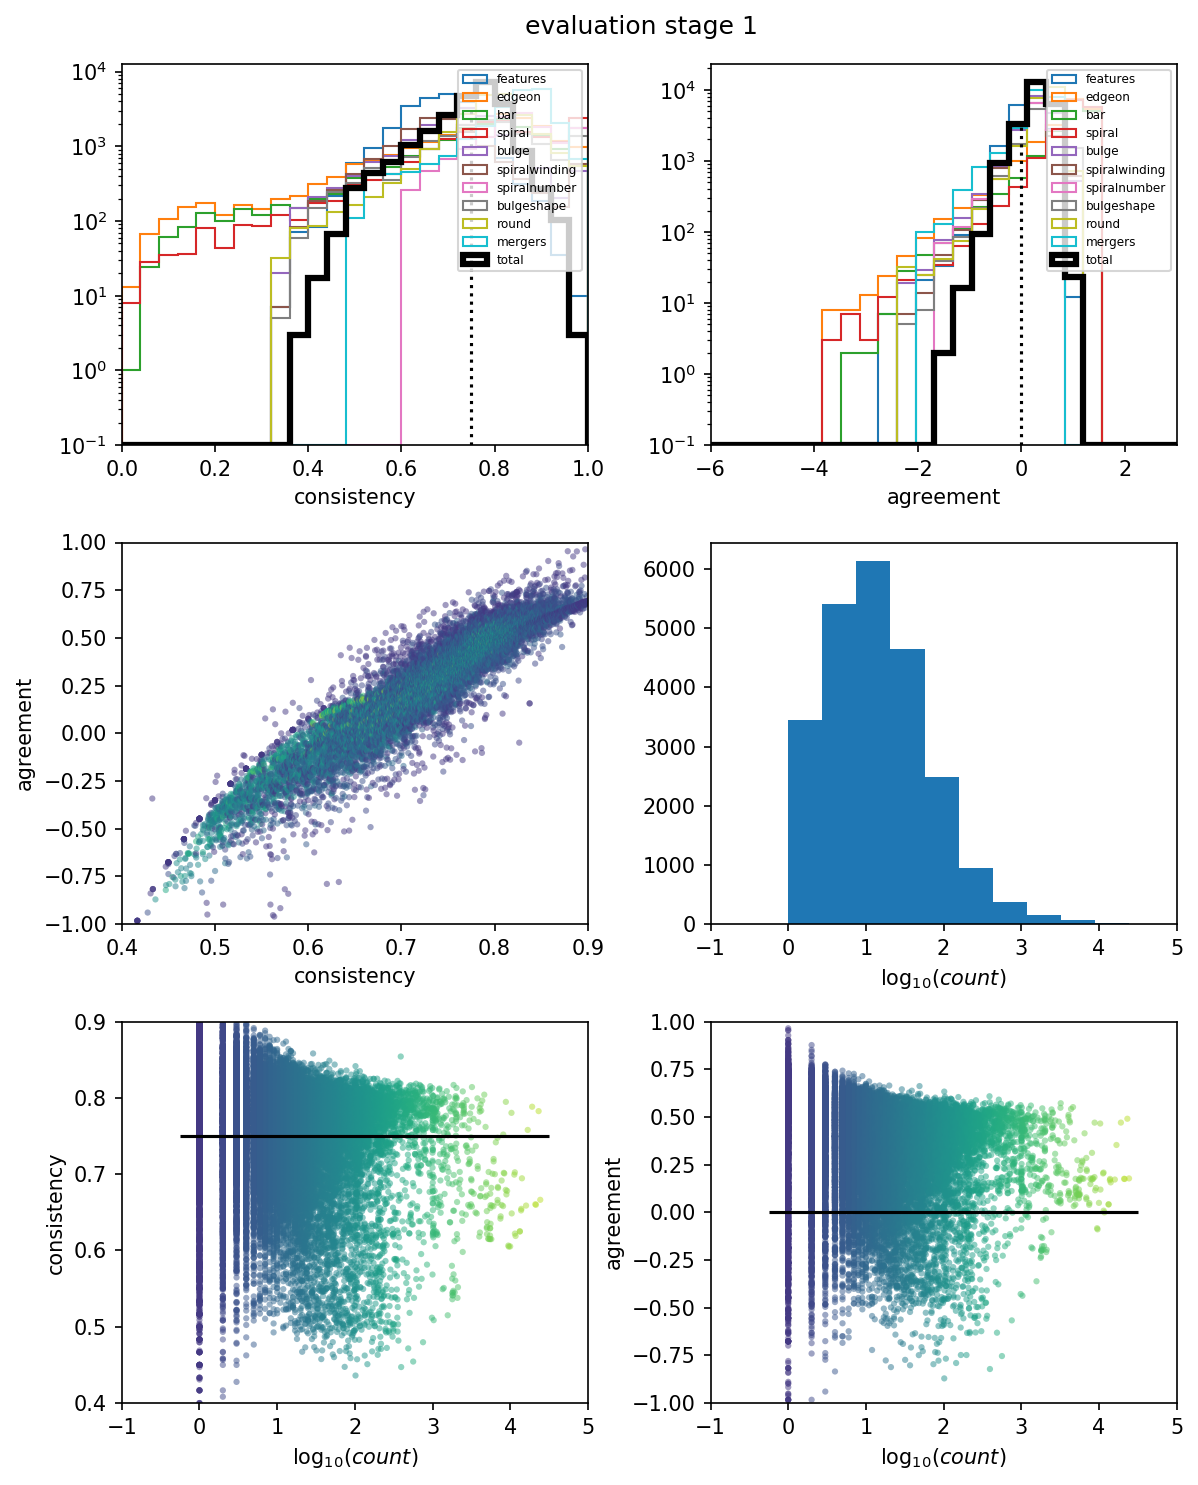

In [26]:
# generate stage 1 evaluation plot
with np.errstate(invalid='ignore'):
    evaluation_plots(evaluation_user, 'evaluation stage 1')
    plt.savefig('{}_evaluation_stage1.pdf'.format(label),
                dpi = 'figure')
    plt.show()
    plt.close()

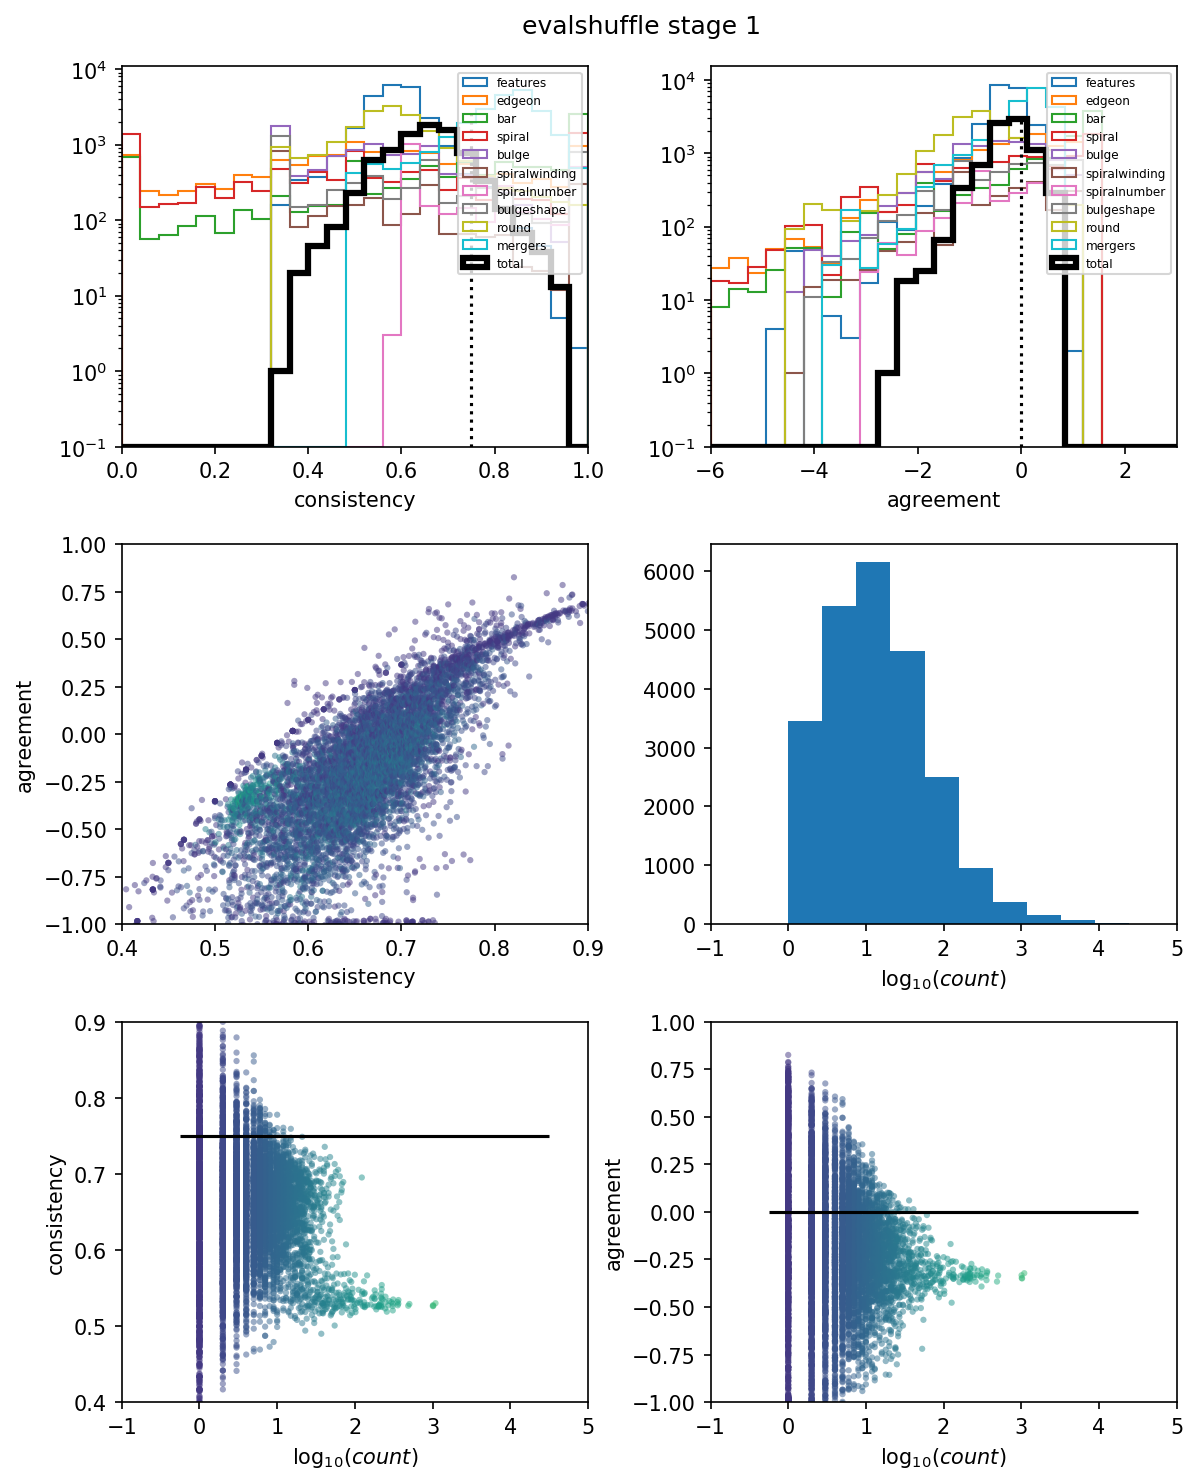

In [27]:
# generate stage 1 evalshuffle plot
with np.errstate(invalid='ignore'):
    evaluation_plots(evalshuffle_user, 'evalshuffle stage 1')
    plt.savefig('{}_evalshuffle_stage1.pdf'.format(label),
                dpi = 'figure')
    plt.show()
    plt.close()

-----------
On stage 2:
-----------



/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiralnumber 2 3
6 spiralnumber 3 4
6 spiralnumber 4 more_than_4
7 bulgeshape 0 rounded
7 bulgeshape 1 boxy
7 bulgeshape 2 no_bulge
8 round 0 completely_round
8 round 1 in_between
8 round 2 cigar_shaped
9 mergers 0 merging
9 mergers 1 tidal_debris
9 mergers 2 both
9 mergers 3 neither
0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiralnumber 2 3
6 spiralnumber 3 4
6 spira

/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


-----------
On stage 3:
-----------

0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiralnumber 2 3
6 spiralnumber 3 4
6 spiralnumber 4 more_than_4
7 bulgeshape 0 rounded
7 bulgeshape 1 boxy
7 bulgeshape 2 no_bulge
8 round 0 completely_round
8 round 1 in_between
8 round 2 cigar_shaped
9 mergers 0 merging
9 mergers 1 tidal_debris
9 mergers 2 both
9 mergers 3 neither
0 features 0 smooth
0 features 1 features
0 features 2 star_or_artifact
1 edgeon 0 yes
1 edgeon 1 no
2 bar 0 bar
2 bar 1 no_bar
3 spiral 0 spiral
3 spiral 1 no_spiral
4 bulge 0 no_bulge
4 bulge 1 obvious
4 bulge 2 dominant
5 spiralwinding 0 tight
5 spiralwinding 1 medium
5 spiralwinding 2 loose
6 spiralnumber 0 1
6 spiralnumber 1 2
6 spiral

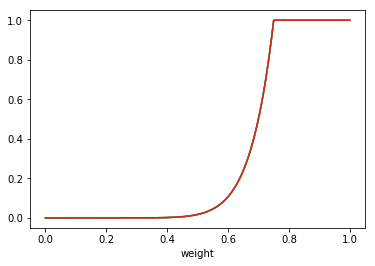

In [28]:
%%time
# iterate user weights beyond stage 1
for i in range(4):
    print(f'-----------\nOn stage {i+2}:\n-----------\n')
    (rawdata,
     clndata,
     evaluation,
     evaluation_user,
     evaluation_user_avg,
     evalshuffle,
     evalshuffle_user,
     evalshuffle_user_avg) = iterate_weights(i+2, rawdata, clndata,
                                             evaluation_user,
                                             label,
                                             user = 'user_id')

In [29]:
# write results to disk
if save_outputs:
    outnames = [binned_outname,
                user_weights_outname,
                cleaned_outname]
    outdatas = [bindata, evaluation_user, clndata]
    for outname, outdata in zip(outnames, outdatas):
        if outname[-3:] == '.gz':
            outname_TEMP = outname[:-3]
            if os.path.exists(outname_TEMP):
                os.remove(outname_TEMP)
            if os.path.exists(outname):
                os.remove(outname)
            outdata.write(outname_TEMP, format='fits')
            cmd = f'gzip --best {outname_TEMP}'
            !{cmd}
        else:
            if os.path.exists(outname):
                os.remove(outname)
            outdata.write(outname, format='fits')

In [30]:
# Notebook finish up
nbt1 = time.time()
nbt1str = time.strftime(nbtf, time.localtime(nbt1))
nbtd = nbt1-nbt0
nbtdstr = time.strftime('%H:%M:%S', time.gmtime(nbtd))
print(f'Notebook end time: \n   {nbt1str} (elapsed: {nbtdstr})')
#--------------------------------68-------------------------------->

Notebook end time: 
   2020-10-19 14:39:05 CDT (elapsed: 01:11:40)
